# Analyse ROMY Events - Master

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import multitaper

from obspy.clients.fdsn import Client

In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
from functions.compute_backazimuth import __compute_backazimuth
from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
from functions.get_event_info import __get_event_info
from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
from functions.compute_cwt import __compute_cwt
from functions.makeplot_waveforms import __makeplot_waveforms

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

# output path for figures
config['path_to_figs'] = data_path+"romy_events/figures/"

# path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

# Event
config['name'] = "Montenegro"
config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
config['tend'] = obs.UTCDateTime("2024-03-14 03:36")
config['trim'] = [0, 0]

#
# config['name'] = "Germany"
# config['tbeg'] = obs.UTCDateTime("2024-03-22 05:31:10")
# config['tend'] = obs.UTCDateTime("2024-03-22 05:34:00")
# # config['trim'] = [60, 20]
# config['trim'] = [80, 40]

#
# config['name'] = "Italy2"
# config['tbeg'] = obs.UTCDateTime("2024-03-27 21:19:00")
# config['tend'] = obs.UTCDateTime("2024-03-27 21:35:00")
# config['trim'] = [30, 20]

#
config['name'] = "Taiwan"
config['tbeg'] = obs.UTCDateTime("2024-04-03 00:11:00")
config['tend'] = obs.UTCDateTime("2024-04-03 03:11:00")
config['trim'] = [0, 0]



# define input data file name
config['filename'] = f"ROMY_{config['name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

# specify client for event information
# config['Client'] = Client("USGS")
config['Client'] = Client("GFZ")

# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941

# create sub directory
if not os.path.isdir(config['path_to_figs']+config['name']):
    os.mkdir(config['path_to_figs']+config['name'])
    config['path_to_figs'] = config['path_to_figs']+config['name']+"/"

config['seis'] = "DROMY"

## Load Data

In [5]:
config, dist, baz, az = __get_event_info(config, min_mag=6.0)

Event:	2024-04-03T00:11:27.770000Z | +24.003, +121.726 | 6.12 mb | manual

	            resource_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/gfz2024gnye")
	          creation_info: CreationInfo(agency_id='GFZ', creation_time=UTCDateTime(2024, 4, 3, 0, 14, 22, 933645))
	    preferred_origin_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20240403080322.007445.1263929")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:org.gfz-potsdam.de/geofon/Origin/20240403080322.007445.1263929/netMag/mb")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
Distance  9449.642921641189 km Azimuth  321.10929061671885 Backazimuth  59.175873709875205


In [6]:
st0 = obs.read(config['path_to_data']+config['filename'])

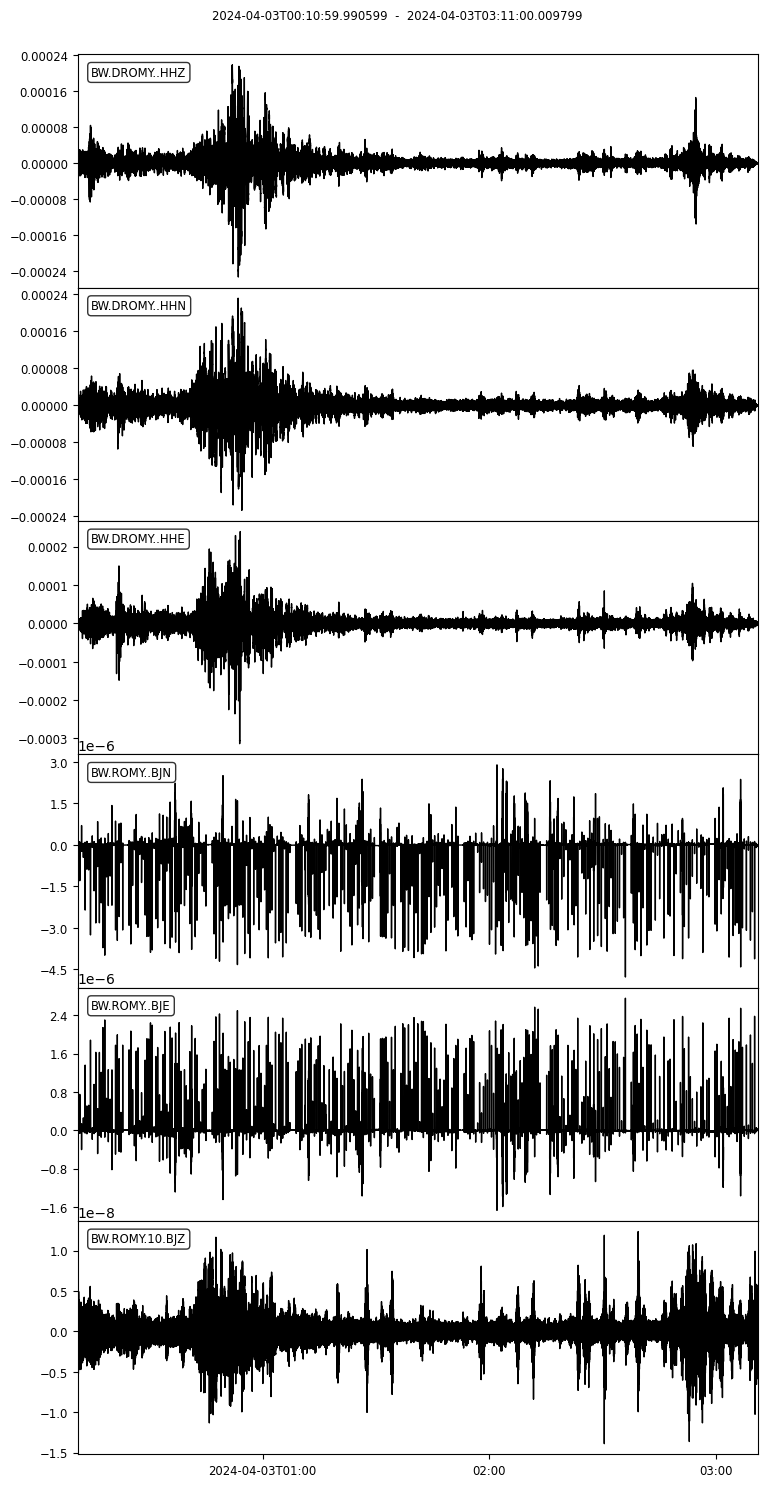

In [7]:
st0.plot(equal_scale=False);

In [8]:
# trim data
st0 = st0.trim(config['tbeg']+config['trim'][0], config['tend']-config['trim'][1])


## Spectra

In [9]:
def __makeplot_waveform_comparison(bspf, adr, submask):

    from obspy.signal.cross_correlation import correlate

    fig, ax = plt.subplots(3, 1, figsize=(15, 5))

    font = 14

    ax[0].plot(bspf.select(channel="*Z")[0].times(), bspf.select(channel="*Z")[0].data, label="BSPF Z")
    ax[0].plot(adr.select(channel="*Z")[0].times(), adr.select(channel="*Z")[0].data, label="ADR Z")

    ax[1].plot(bspf.select(channel="*N")[0].times(), bspf.select(channel="*N")[0].data, label="BSPF N")
    ax[1].plot(adr.select(channel="*N")[0].times(), adr.select(channel="*N")[0].data, label="ADR N")

    ax[2].plot(bspf.select(channel="*E")[0].times(), bspf.select(channel="*E")[0].data, label="BSPF E")
    ax[2].plot(adr.select(channel="*E")[0].times(), adr.select(channel="*E")[0].data, label="ADR E")

    cc_Z = round(correlate(bspf.select(channel="*Z")[0].data, adr.select(channel="*Z")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_N = round(correlate(bspf.select(channel="*N")[0].data, adr.select(channel="*N")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)
    cc_E = round(correlate(bspf.select(channel="*E")[0].data, adr.select(channel="*E")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 1)

    for i in range(3):
        ax[i].legend(loc=1, ncols=4)
        ax[i].grid(which="both", alpha=0.5)
        # ax[i].set_xscale("log")
        ax[i].set_ylabel("rot. rate (rad/s)")

    ax[2].set_xlabel("Frequency (Hz)")
    ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CCz = {cc_Z} | CCn = {cc_N} | CCe = {cc_E}")

    plt.show();
    return fig

DPSS using interpolation 216001 100000
DPSS using interpolation 216001 100000
DPSS using interpolation 216001 100000
DPSS using interpolation 216001 100000
DPSS using interpolation 216001 100000
DPSS using interpolation 216001 100000


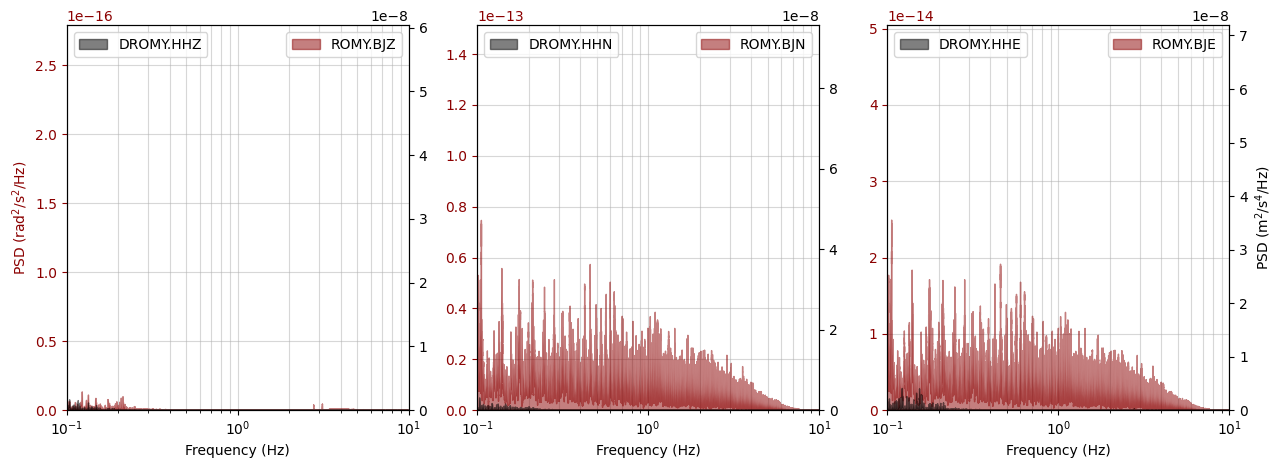

In [10]:

acc0 = st0.select(station=f"{config['seis']}", channel="*H*").copy()
rot0 = st0.select(station="ROMY", channel="*J*").copy()

rot0 = rot0.detrend("simple")
acc0 = acc0.detrend("simple")

fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=0.1, fmax=10, ylog=False, xlog=True, fill=True)

fig.savefig(config['path_to_figs']+f"ROMY_{config['name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');


### Continueous Wavelet Transform

In [3]:
outs = {}
for component in ["E", "N", "Z"]:

    ttt = rot0[0].times()
    arr = rot0.select(channel=f"*{component}")[0].data
    dt = rot0[0].stats.delta # seconds

    out = __compute_cwt(ttt, arr, dt, tscale="sec",
                        datalabel=f"ROMY-{component}",
                        period=False,
                        ymax=10,
                        plot=True,
                        log=True,
                       )

    # add to dict
    outs[component] = out

    # store image
    out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_cwt_{component}.png",
                       format="png", dpi=150, bbox_inches='tight');


NameError: name 'rot0' is not defined

In [2]:
def __makeplot_cwt_all(st0, out, clog=False, ylim=None):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 2)

    tscale = 1

    times = st0.select(channel="*N")[0].times()*tscale

    Ncol, Nrow = 1, 9

    font = 12

    cmap = plt.get_cmap("viridis")

    tilt_scale, tilt_unit = 1e9, f"nrad/s"

    fig = plt.figure(figsize=(15, 8))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:3, :])
    ax3 = fig.add_subplot(gs[3, :])
    ax4 = fig.add_subplot(gs[4:6, :])
    ax5 = fig.add_subplot(gs[6, :])
    ax6 = fig.add_subplot(gs[7:9, :])

    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    Z = st0.select(channel="*Z")[0].data*tilt_scale
    N = st0.select(channel="*N")[0].data*tilt_scale
    E = st0.select(channel="*E")[0].data*tilt_scale

    periodZ = outs['Z']['frequencies']
    periodN = outs['N']['frequencies']
    periodE = outs['N']['frequencies']

    # _______________________________________________________________
    #
    ax1.plot(times, N, color="k", label="N", lw=1)
    ax1.set_xlim(min(times), max(times))
    ax1.legend(loc=1)
    ax1.set_xticklabels([])

    if clog:
        vmin, vmax, norm = 0.01, 1, "log"
    else:
        vmin, vmax, norm = 0.0, 0.9, None
    # _______________________________________________________________
    #
    im1 = ax2.pcolormesh(out['N']['times']*tscale, periodN, out['N']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax2.plot(out['N']['times']*tscale, out['N']['cone'], color="white", ls="--")
    ax2.fill_between(out['N']['times']*tscale, out['N']['cone'], min(periodN)*np.ones(len(out['N']['cone'])), color="white", alpha=0.2)
    ax2.set_xticklabels([])

    if ylim is None:
        ax2.set_ylim(min(periodN), max(periodN))
    else:
        ax2.set_ylim(min(periodN), ylim)

    # _______________________________________________________________
    #
    ax3.plot(times, E, color="k", label="E", lw=1)
    ax3.set_xlim(min(times), max(times))
    ax3.legend(loc=1)
    ax3.set_xticklabels([])

    # _______________________________________________________________
    #
    im2 = ax4.pcolormesh(out['E']['times']*tscale, periodE, out['E']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax4.plot(out['E']['times']*tscale, out['E']['cone'], color="white", ls="--")
    ax4.fill_between(out['E']['times']*tscale, out['E']['cone'], min(periodE)*np.ones(len(out['E']['cone'])), color="white", alpha=0.2)
    ax4.set_xticklabels([])

    if ylim is None:
        ax4.set_ylim(min(periodE), max(periodE))
    else:
        ax4.set_ylim(min(periodE), ylim)

    # _______________________________________________________________
    #
    ax5.plot(times, Z, color="k", label="Z", lw=1)
    ax5.set_xlim(min(times), max(times))
    ax5.legend(loc=1)
    ax5.set_xticklabels([])

    # _______________________________________________________________
    #
    im3 = ax6.pcolormesh(out['Z']['times']*tscale, periodE, out['Z']['cwt_power'],
                         cmap=cmap,
                         vmin=vmin,
                         vmax=vmax,
                         norm=norm,
                        )
    ax6.plot(out['Z']['times']*tscale, out['Z']['cone'], color="white", ls="--")
    ax6.fill_between(out['Z']['times']*tscale, out['Z']['cone'], min(periodZ)*np.ones(len(out['Z']['cone'])), color="white", alpha=0.2)

    if ylim is None:
        ax6.set_ylim(min(periodZ), max(periodZ))
    else:
        ax6.set_ylim(min(periodZ), ylim)

    # _______________________________________________________________
    #
    ax1.set_ylabel(f"$\Omega$ ({tilt_unit})", fontsize=font)
    ax2.set_ylabel(f"Frequency (Hz)", fontsize=font)
    ax3.set_ylabel(f"$\Omega$ ({tilt_unit})", fontsize=font)
    ax4.set_ylabel(f"Frequency (Hz)", fontsize=font)
    ax5.set_ylabel(f"$\Omega$ ({tilt_unit})", fontsize=font)
    ax6.set_ylabel(f"Frequency (Hz)", fontsize=font)

    ax6.set_xlabel(f"Time (s) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)


    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2, color="w")
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2, color="w")
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2, color="w")

    # add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="max")
    cb.set_label("norm. continuous wavelet transform power", fontsize=font, labelpad=5, color="black")

#     ax1.set_title(f"bandpass = {pmax} - {pmin} hours")

    plt.plot();
    return fig

fig = __makeplot_cwt_all(rot0, outs, clog=True, ylim=1)


NameError: name 'rot0' is not defined

### Cross Wavelet Transform

In [ ]:

out = __compute_cross_wavelet_transform(
                                        rot0[0].times(),
                                        rot0.select(channel=f"*{component}")[0].data,
                                        acc0.select(channel=f"*{component}")[0].data,
                                        rot0[0].stats.delta,
                                        xwt_threshold=0.,
                                        ymax=10,
                                        normalize=False,
                                        ylog=True,
                                        clog=True,
                                        plot=True,
)

out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_xwt_{component}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [ ]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

for component in ["Z", "N", "E"]:

    st1 = st0.copy()

    st1 = st1.detrend("demean").taper(0.01, type="cosine").filter("bandpass", freqmin=0.01, freqmax=10, corners=4, zerophase=True)

    s1 = st1.select(station="ROMY", channel=f"*{component}")[0].data
    s2 = st1.select(station=f"{config['seis']}", channel=f"*{component}")[0].data

    plot_tf_misfits(s1, s2, dt=st1[0].stats.delta, fmin=0.01, fmax=20, show=True, norm="global")


## Filter

In [ ]:

fmin, fmax = 0.5, 5

rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station="FUR", channel="*H*").copy()

rot1 = rot1.detrend("linear").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.01, type="cosine").filter("bandpass", freqmin=fmin, freqmax=fmax, corners=8, zerophase=True);

for tr in acc1:
    if "Z" in tr.stats.channel:
        tr.data *= -1

# for tr in rot1:
#     if "Z" in tr.stats.channel:
#         tr.data = np.roll(tr.data, 3)


In [ ]:
fig = __makeplot_waveforms(acc1, rot1);

fig.savefig(config['path_to_figs']+f"ROMY_{config['name']}_waveforms.png", format="png", dpi=200, bbox_inches='tight')


## Waveform Comparison

In [ ]:

fig = __makeplot_waveform_comparison_cc(rot1, acc1, baz, fmin, fmax, dist, twin_sec=2, twin_overlap=0.5)

fig.savefig(config['path_to_figs']+f"ROMY_{config['name']}_waveforms_cc.png", format="png", dpi=150, bbox_inches='tight');


In [ ]:
fig = __makeplot_comparison_ccf(rot1, acc1, baz, dist, twin_sec=1, twin_overlap=0.5, fmin=fmin, fmax=fmax)

## Backazimuth

In [ ]:
from functions.compute_backazimuth import __compute_backazimuth
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent
from functions.compare_backazimuth_codes import __compare_backazimuth_codes

In [ ]:
config['station_longitude'] = config['sta_lon']
config['station_latitude']  = config['sta_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 2

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1


baz, az, dist = __get_theoretical_backazimuth(config['sta_lat'], config['sta_lon'], event_obj=config['event'], fdsn_client='USGS')


In [ ]:
out1 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='love',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out1['fig'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_baz_love_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out2 = __compute_backazimuth(
                            acc1,
                            rot1,
                            config,
                            wave_type='rayleigh',
                            event=config['event'],
                            plot=True,
                            flim=(fmin, fmax),
                            invert_rot_z=False,
                            show_details=False,
)

out2['fig'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_baz_rayleigh_{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


out3 = __compute_backazimuth_tangent(
                                    rot1,
                                    acc1,
                                    win_time_s=config['win_length_sec'],
                                    overlap=config['overlap']/100,
                                    baz_theo=baz,
                                    cc_thres=0.1,
                                    plot=True,
                                    invert_acc_z=False,
                                    )

out3['fig'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_baz_tangent_{rot1[0].stats.station}{fmin}_{fmax}.png", dpi=150, bbox_inches='tight', pad_inches=0.05)


In [ ]:
out4 = __compare_backazimuth_codes(rot1, acc1, config['event'], fmin, fmax,
                                   config['win_length_sec'], config['overlap'],
                                   cc_thres=0.5, invert_acc_z=False, invert_rot_z=False, plot=True,
                                  );

out4['fig3'].savefig(config['path_to_figs']+f"ROMY_{config['name']}_baz_comparison_{rot1[0].stats.location}_{fmin}_{fmax}_all.png", dpi=150, bbox_inches='tight', pad_inches=0.05);


## Phase Velocity

In [ ]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [ ]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot1,
                                                acc1,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=config['win_length_sec'],
                                                cc_thres=0.8,
                                                overlap=config['overlap']/100,
                                                flim=(fmin, fmax),
                                                plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_velocity_love_{rot1[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot1,
                                                acc1,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=config['win_length_sec'],
                                                cc_thres=0.8,
                                                overlap=config['overlap']/100,
                                                flim=(fmin, fmax),
                                                plot=True,
)

# out['fig'].savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_velocity_rayleigh_{rot1[0].stats.station}_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


### Velocity in F-Bands

In [ ]:
from functions.estimate_velocity_in_fbands import __estimate_velocity_in_fbands

In [ ]:
fig1, fig2 = __estimate_velocity_in_fbands(rot0, acc0, baz)


# fig1.savefig(config['path_to_figs']+f"BSFP_M42_Love_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

# fig2.savefig(config['path_to_figs']+f"BSFP_M42_Rayleigh_velocity_fbands_{rot[0].stats.station}_{rot[0].stats.location}.png", format="png", dpi=200, bbox_inches='tight')

## BAZ in F-Bands ??

In [ ]:
def __estimate_baz_in_fbands():

    # flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="one-third-octave", plot=False)
    flower, fupper, fcenter = __get_octave_bands(0.5, 10, fband_type="octave", plot=False)
    fbands = [(f1, f2) for f1, f2 in zip(flower, fupper)]


    # fbands = [(0.5,0.7), (0.7,0.9), (0.8,1.0), (1.0,2.0), (1.0,5.0), (3.0,8.0)]

    backazis = []
    flabels = []

    angles = np.arange(0, 365, 5)

    for fmin, fmax in fbands:

        print(fmin, fmax)

        acc = st0.select(station="PFO").copy();
        rot = st0.select(station="BSPF").copy();
        # rot = st0.select(station="RPFO").copy();

        rot = rot.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);
        acc = acc.detrend("demean").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8);

        win_time_s = 1/fmin
        cc_threshold = 0.2
        overlap = 0.9



        out3 = __compute_backazimuth_tangent(
                                            rot,
                                            acc,
                                            win_time_s=win_time_s,
                                            overlap=overlap,
                                            baz_theo=None,
                                            cc_thres=cc_threshold,
                                            plot=False,
        )


        if len(out3['baz_est']) > 0:
            hist = np.histogram(out3['baz_est'], bins=len(angles)-1, range=[min(angles), max(angles)], weights=(out3['ccoef']*100).astype(int), density=False)
            dat = np.concatenate([np.ones(int(nnn))*val for nnn, val in zip( hist[0], hist[1])], axis=0 )
            backazis.append(dat)
            flabels.append(f"{round(fmin,1)}-{round(fmax,1)}Hz")
        else:
            print(f"empty results")


    fig, ax = plt.subplots(1, 1, figsize=(15,5))


    ax.yaxis.grid(True)

    ax.violinplot(backazis, showmeans=False, showmedians=True, showextrema=True)

    ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
    ax.set_xticks([y + 1 for y in range(len(data))], labels=flabels)

    ax.set_title(f" {acc[0].stats.station} - {rot[0].stats.station} | Overlap = {int(overlap*100)} % | CC_limit = {cc_threshold}")

    ax.set_ylim(0, 360)

    # fig.savefig(config['path_to_figs']+f"BSFP_Rayleigh_velocity_fbands_{rot[0].stats.station}.png", format="png", dpi=200, bbox_inches='tight')

    plt.show();

# __estimate_baz_in_fbands()